# MINST数据的CNN模型（含GPU加速）

In [4]:
import numpy as np
from tqdm import tqdm

from Nyatorch import nn
from Nyatorch.utils import CrossEntropy, GradientDescent, accuracy
from Nyatorch.utils.data import MINST_loader

## 加载MINST数据集

In [5]:
train, test = MINST_loader(conv=True, batch_size=64)

## 定义网络

In [6]:
# 使用GPU运算时，需要cuda核心
# 如果不能使用GPU运算，把这里的GPU去掉即可
net = nn.Sequential(
    nn.Conv2dGPU(1, 4, 3),
    nn.ReLU(),
    nn.Conv2dGPU(4, 8, 3),
    nn.ReLU(),
    nn.MaxPoolingGPU(2),
    nn.Flatten(),
    nn.LinearLayer(1152, 512),
    nn.Sigmoid(),
    nn.LinearLayer(512, 10),
)

## 定义参数和损失函数

In [9]:
num_epochs = 6
learning_rate = 0.001
loss = CrossEntropy()
net.def_loss(loss)
optimizer = GradientDescent(net, learning_rate)


## 训练

In [10]:
# 这里可以加载模型进行重复训练
# net.load_module()

for epoch in range(num_epochs):
    total_loss = 0

    for inputs, target in tqdm(train):
        outputs = net(inputs)
        net.backward(target)
        total_loss += loss.calculate(outputs, target) / len(train)
        optimizer.update()

    if (epoch + 1) % 2 == 0:
        print(f"Epoch {epoch + 1}, Loss: {total_loss}")

# 保存模型
net.save_module()

100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:38<00:00, 24.13it/s]


Epoch 2, Loss: 0.29412680397474056


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:39<00:00, 23.90it/s]


Epoch 4, Loss: 0.24895588457570098


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:38<00:00, 24.09it/s]

Epoch 6, Loss: 0.21958279399233346


## 测试

In [11]:
# net.load_module()

train_corrects = 0
for x, y in train:
    train_corrects += accuracy(net(x), y) / len(train)
print(f"train accuracy: {train_corrects}")

test_corrects = 0
for x, y in test:
    test_corrects += accuracy(net(x), y) / len(test)
print(f"test accuracy: {test_corrects}")

train accuracy: 94.64785447761243
test accuracy: 94.62579617834402


## 输出混淆矩阵

<Axes: >

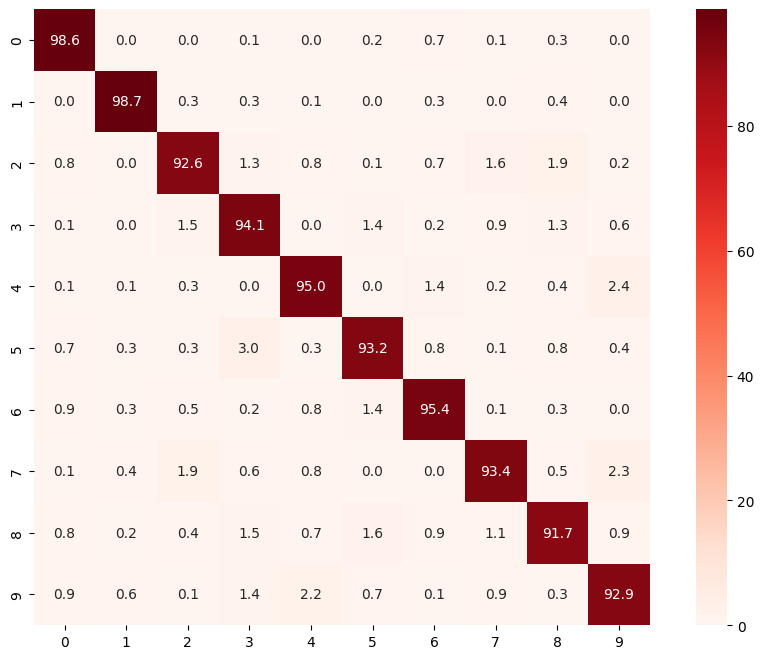

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#net.load_module()
plt.figure(figsize=(12, 8))

# 获得预测值和标签值
total_pred_y, total_label_y = np.empty((0, 10)), np.empty((0, 10))
for x, label_y in test:
    pred_y = net(x)
    total_pred_y = np.concatenate((total_pred_y, pred_y), axis=0)
    total_label_y = np.concatenate((total_label_y, label_y), axis=0)

# 输出混淆矩阵
cm = confusion_matrix(y_true=np.argmax(total_label_y, axis=1), y_pred=np.argmax(total_pred_y, axis=1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.0
sns.heatmap(cm, annot=True, cmap='Reds', fmt='.1f', square=True)